## 01. 데이터 결측치 처리

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

import koreanize_matplotlib

# 결측치 확인하는 라이브러리
import missingno as msno

# seaborn의 다른 라이브러리
import seaborn.objects as so

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install koreanize-matplotlib

In [4]:
!pip install missingno

In [5]:
train = pd.read_csv('../과제 데이터/train.csv', encoding='cp949')
df=train.copy()

df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,24/10/2018,1492,16,NaN,42,1.3,1976,5.0,1.22,0.0,0.0,NaN,No Holiday,Yes
1,01/05/2018,1536,14,23.0,64,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes
2,14/11/2018,327,2,6.2,59,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes
3,31/08/2018,170,4,23.2,83,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes
4,26/06/2018,45,5,23.7,64,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,08/02/2018,255,7,-9.6,67,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes
7004,28/03/2018,104,4,10.6,77,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes
7005,30/04/2018,569,0,14.7,54,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes
7006,29/05/2018,2234,8,20.5,66,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            6306 non-null   float64
 4   Humidity(%)                7008 non-null   int64  
 5   Wind speed (m/s)           6303 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    6309 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

In [7]:
df.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              702
Humidity(%)                    0
Wind speed (m/s)             705
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      699
Holiday                        0
Functioning Day                0
dtype: int64

<Axes: >

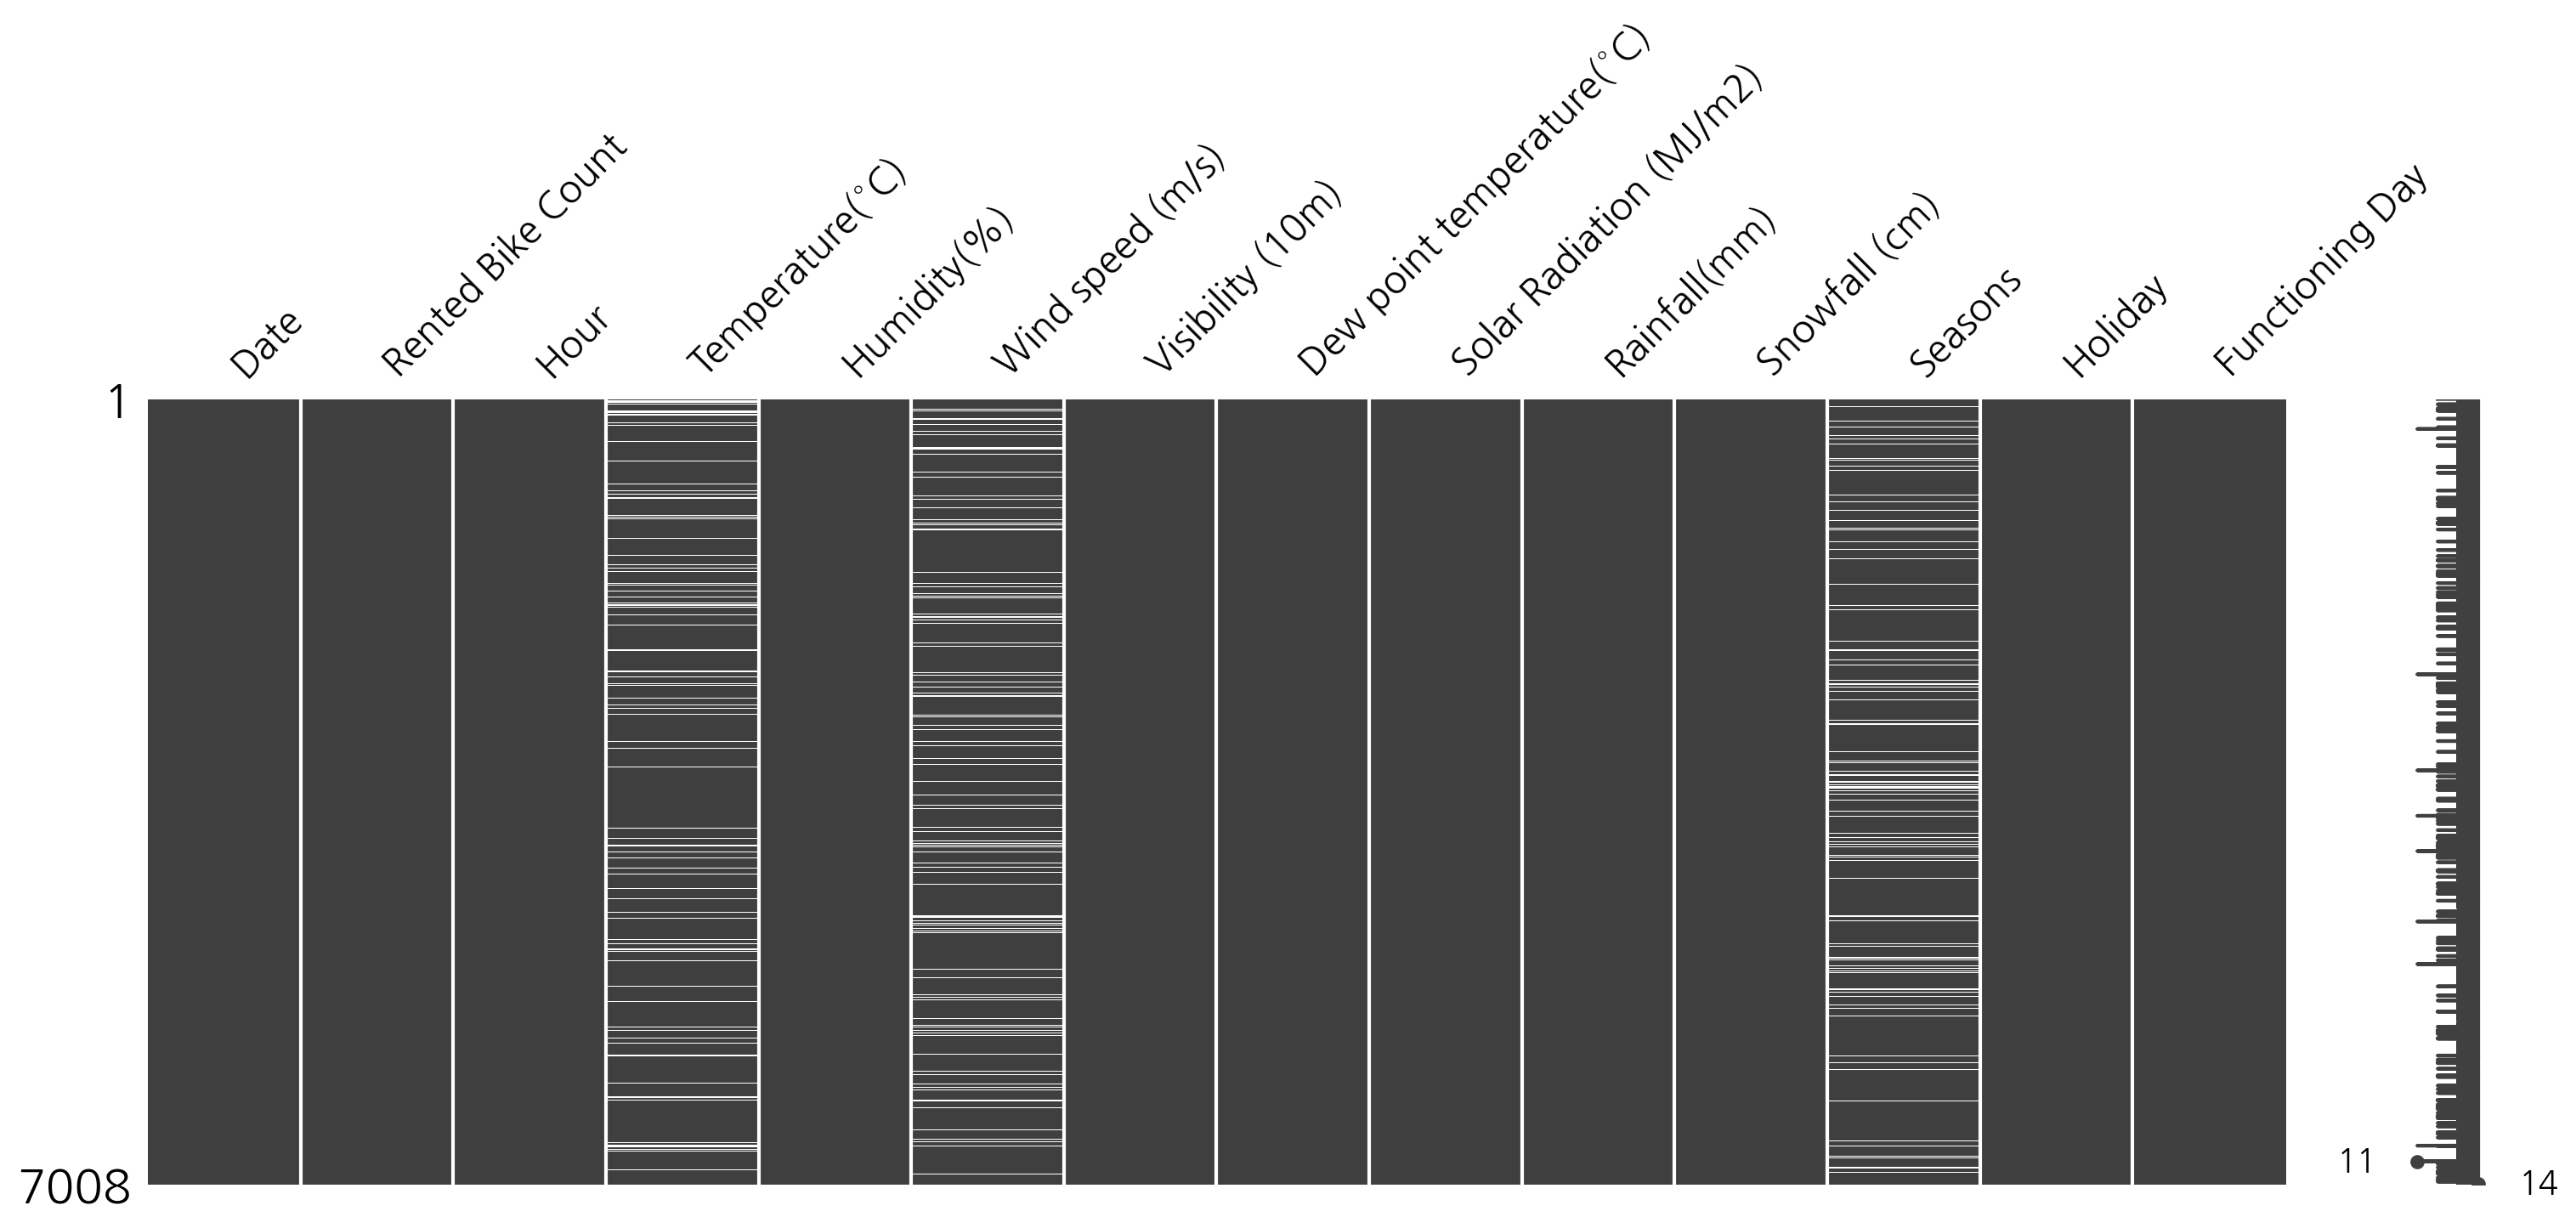

In [8]:
msno.matrix(df, figsize=(18,6))

### 01-1. 계절 결측치 임퓨테이션

In [9]:
df['month'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['month'] = df['month'].dt.month
df.groupby('month')['Seasons'].value_counts(dropna=False)

month  Seasons
1      Winter     543
       NaN         73
2      Winter     496
       NaN         44
3      Spring     523
       NaN         47
4      Spring     507
       NaN         63
5      Spring     524
       NaN         63
6      Summer     522
       NaN         62
7      Summer     553
       NaN         55
8      Summer     523
       NaN         56
9      Autumn     520
       NaN         59
10     Autumn     540
       NaN         59
11     Autumn     527
       NaN         55
12     Winter     531
       NaN         63
Name: count, dtype: int64

In [10]:
# 월별 계절 매핑 딕셔너리 생성
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

# 'month' 열을 기준으로 계절을 매핑하여 결측치 채우기
df['Seasons'] = df.apply(lambda row: season_mapping.get(row['month'], np.nan) if pd.isna(row['Seasons']) else row['Seasons'], axis=1)

# 결측이 남아있는지 확인
df.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              702
Humidity(%)                    0
Wind speed (m/s)             705
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
month                          0
dtype: int64

In [11]:
# 'Seasons' 열에서 결측치가 있는 행을 제외
no_nan_Seasons = df[df['Seasons'].notna()]

# 'Seasons' 열의 값별로 행의 개수를 계산
season_counts = no_nan_Seasons['Seasons'].value_counts()

# 결과 출력
print(season_counts)

Seasons
Summer    1771
Autumn    1760
Winter    1750
Spring    1727
Name: count, dtype: int64


In [12]:
# 결측값을 채우기 위한 함수 정의
def fill_nan_temperature(row, stats_by_season_hour):
    if pd.isna(row['Temperature(°C)']):
        season = row['Seasons']
        hour = row['Hour']
        mean_temperature = stats_by_season_hour.loc[(season, hour), 'mean']
        std_deviation = stats_by_season_hour.loc[(season, hour), 'std']
        return np.random.normal(loc=mean_temperature, scale=std_deviation)
    else:
        return row['Temperature(°C)']

def fill_nan_temperatures(dataframe):
    # 계절과 시간대별 평균 및 표준편차 계산
    stats_by_season_hour = dataframe.groupby(['Seasons', 'Hour'])['Temperature(°C)'].agg(['mean', 'std'])
    
    # apply 메서드를 사용하여 결측값 채우기
    dataframe['Temperature(°C)'] = dataframe.apply(lambda row: fill_nan_temperature(row, stats_by_season_hour), axis=1)

# 데이터프레임에 결측값 채우기
fill_nan_temperatures(df)

# 결과 출력
print(df)

            Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0     24/10/2018               1492    16        12.023117           42   
1     01/05/2018               1536    14        23.000000           64   
2     14/11/2018                327     2         6.200000           59   
3     31/08/2018                170     4        23.200000           83   
4     26/06/2018                 45     5        23.700000           64   
...          ...                ...   ...              ...          ...   
7003  08/02/2018                255     7        -9.600000           67   
7004  28/03/2018                104     4        10.600000           77   
7005  30/04/2018                569     0        14.700000           54   
7006  29/05/2018               2234     8        20.500000           66   
7007  20/09/2018               1290    17        19.300000           76   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                  1.3      

In [13]:
df.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)                0
Humidity(%)                    0
Wind speed (m/s)             705
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
month                          0
dtype: int64

### 01-2. 풍속 결측치 임퓨테이션

In [14]:
# 수치형 데이터만 선택
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# 상관관계 매트릭스 계산
correlation_matrix = df_numeric.corr()

# 'Wind speed (m/s)'와 다른 변수 간의 상관관계 출력
wind_speed_correlation = correlation_matrix['Wind speed (m/s)'].sort_values(ascending=False)
print(wind_speed_correlation)

Wind speed (m/s)             1.000000
Solar Radiation (MJ/m2)      0.330813
Hour                         0.282618
Visibility (10m)             0.173654
Rented Bike Count            0.116835
Snowfall (cm)               -0.000302
Rainfall(mm)                -0.013948
Temperature(°C)             -0.039001
Dew point temperature(°C)   -0.186479
Humidity(%)                 -0.342188
Name: Wind speed (m/s), dtype: float64


In [15]:
!pip install fancyimpute

In [16]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


### 01-3. 습도 결측치 임퓨테이션

In [17]:
from sklearn.impute import KNNImputer

# 수치형 데이터만 선택
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# KNN 임퓨테이션을 사용해 결측치를 채우기
features = ['Humidity(%)', 'Solar Radiation (MJ/m2)', 'Wind speed (m/s)']
X = df_numeric[features].values

# KNN 모델을 사용하여 결측치 채우기
knn_imputer = KNNImputer(n_neighbors=3)  # k는 가까운 이웃의 수
X_imputed = knn_imputer.fit_transform(X)

# 결과를 데이터프레임으로 변환
df_numeric_imputed = pd.DataFrame(X_imputed, columns=features)

# 원본 데이터프레임에 대체된 값 반영
df[features] = df_numeric_imputed

# 결과 출력
print(df)

            Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0     24/10/2018               1492    16        12.023117         42.0   
1     01/05/2018               1536    14        23.000000         64.0   
2     14/11/2018                327     2         6.200000         59.0   
3     31/08/2018                170     4        23.200000         83.0   
4     26/06/2018                 45     5        23.700000         64.0   
...          ...                ...   ...              ...          ...   
7003  08/02/2018                255     7        -9.600000         67.0   
7004  28/03/2018                104     4        10.600000         77.0   
7005  30/04/2018                569     0        14.700000         54.0   
7006  29/05/2018               2234     8        20.500000         66.0   
7007  20/09/2018               1290    17        19.300000         76.0   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                  1.3      

In [18]:
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
month                        0
dtype: int64

In [19]:
df.to_csv('../과제 데이터/train_new.csv', index=False)

## 02. 선형회귀 모델에 맞는 2차 전처리

### 02-1. 범주형 데이터 수치화

In [20]:
df = pd.read_csv('../과제 데이터/train_new.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            7008 non-null   float64
 4   Humidity(%)                7008 non-null   float64
 5   Wind speed (m/s)           7008 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    7008 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

> 변수 종류

Date : 날짜(2017년 12월 1일~2018년 10월 31일)

Rented Bike Count : 해당 시간별 자전거 대여량

Hour : 시간(0~23)

Temperature(°C) : 온도

Humidity(%) : 습도

Wind speed (m/s) : 풍속

Visibility (10m) : 가시성

Dew point temperature(°C) : 이슬점 온도

Solar Radiation (MJ/m2) : 태양복사에너지

Rainfall(mm) : 강우량

Snowfall (cm) : 강설량

Seasons : 계절(Spring, Summer, Autumn, Winter)

Holiday : 공휴일 여부(Holiday, No Holiday)

Functioning Day : 운영일 여부(Yes, No)

month : 월

> 변수의 데이터 타입

In [21]:
for column in df.columns:
    dtype = df[column].dtype
    if pd.api.types.is_numeric_dtype(dtype):
        print(f'{column}: 수치형')
    elif pd.api.types.is_categorical_dtype(dtype):
        print(f'{column}: 범주형')
    elif pd.api.types.is_object_dtype(dtype):
        print(f'{column}: 명목형')
    else:
        print(f'{column}: etc')

Date: 명목형
Rented Bike Count: 수치형
Hour: 수치형
Temperature(°C): 수치형
Humidity(%): 수치형
Wind speed (m/s): 수치형
Visibility (10m): 수치형
Dew point temperature(°C): 수치형
Solar Radiation (MJ/m2): 수치형
Rainfall(mm): 수치형
Snowfall (cm): 수치형
Seasons: 명목형
Holiday: 명목형
Functioning Day: 명목형
month: 수치형


#### 명목형: Date, Sesons, Holiday, Functioning Day
Date: DD-MM-YYYY로 이루어져 있으므로 각각 Year, Month, Day로 나눈다

Year, Month, Day를 포함한 문자형 변수는  OneHotEncoding을 통해 수치형 데이터로 바꾼다.

#### 

In [22]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,year,day
0,2018-10-24,1492,16,12.023117,42.0,1.3,1976,5.0,1.22,0.0,0.0,Autumn,No Holiday,Yes,10,2018,24
1,2018-05-01,1536,14,23.000000,64.0,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes,5,2018,1
2,2018-11-14,327,2,6.200000,59.0,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes,11,2018,14
3,2018-08-31,170,4,23.200000,83.0,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes,8,2018,31
4,2018-06-26,45,5,23.700000,64.0,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes,6,2018,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-02-08,255,7,-9.600000,67.0,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes,2,2018,8
7004,2018-03-28,104,4,10.600000,77.0,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes,3,2018,28
7005,2018-04-30,569,0,14.700000,54.0,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes,4,2018,30
7006,2018-05-29,2234,8,20.500000,66.0,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes,5,2018,29


In [23]:
# Seasons, Holiday, Functioning Day 더미변수화
df_dummy = pd.get_dummies(df[["Seasons","Holiday","Functioning Day"]])
df_dummy

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,True,False,False,False,False,True,False,True
1,False,True,False,False,True,False,False,True
2,True,False,False,False,False,True,False,True
3,False,False,True,False,False,True,False,True
4,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...
7003,False,False,False,True,False,True,False,True
7004,False,True,False,False,False,True,False,True
7005,False,True,False,False,False,True,False,True
7006,False,True,False,False,False,True,False,True


In [24]:
df_copy = df.copy()

df_copy = pd.concat([df_copy, df_dummy], axis=1)
df_copy

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),...,year,day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,2018-10-24,1492,16,12.023117,42.0,1.3,1976,5.0,1.22,0.0,...,2018,24,True,False,False,False,False,True,False,True
1,2018-05-01,1536,14,23.000000,64.0,2.8,520,15.8,1.59,0.0,...,2018,1,False,True,False,False,True,False,False,True
2,2018-11-14,327,2,6.200000,59.0,0.6,1584,-1.2,0.00,0.0,...,2018,14,True,False,False,False,False,True,False,True
3,2018-08-31,170,4,23.200000,83.0,1.6,1102,20.1,0.00,0.0,...,2018,31,False,False,True,False,False,True,False,True
4,2018-06-26,45,5,23.700000,64.0,0.9,876,16.4,0.00,0.1,...,2018,26,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-02-08,255,7,-9.600000,67.0,1.0,1503,-14.5,0.00,0.0,...,2018,8,False,False,False,True,False,True,False,True
7004,2018-03-28,104,4,10.600000,77.0,0.9,422,6.7,0.00,0.0,...,2018,28,False,True,False,False,False,True,False,True
7005,2018-04-30,569,0,14.700000,54.0,1.3,718,5.4,0.00,0.0,...,2018,30,False,True,False,False,False,True,False,True
7006,2018-05-29,2234,8,20.500000,66.0,1.7,1062,13.9,0.34,0.0,...,2018,29,False,True,False,False,False,True,False,True


In [25]:
ohe = OneHotEncoder(sparse_output=False)

result_ohe = ohe.fit_transform(df_copy[["Seasons", "Holiday", "Functioning Day"]])
result_ohe

array([[1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.]])

In [26]:
ohe.categories_
df_ohe = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(["Seasons","Holiday","Functioning Day"]))
df_ohe.astype(int)

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,1,0,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1
2,1,0,0,0,0,1,0,1
3,0,0,1,0,0,1,0,1
4,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...
7003,0,0,0,1,0,1,0,1
7004,0,1,0,0,0,1,0,1
7005,0,1,0,0,0,1,0,1
7006,0,1,0,0,0,1,0,1


In [27]:
print(df_copy.dtypes)

Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                         float64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
month                                 int32
year                                  int32
day                                   int32
Seasons_Autumn                         bool
Seasons_Spring                         bool
Seasons_Summer                         bool
Seasons_Winter                         bool
Holiday_Holiday                        bool
Holiday_No Holiday              

In [28]:
# 새롭게 대체된 변수가 있는 이전 변수는 없앤다
df_final = df_copy.drop(["Date", "Seasons", "Holiday", "Functioning Day"], axis=1)
df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          7008 non-null   int64  
 1   Hour                       7008 non-null   int64  
 2   Temperature(°C)            7008 non-null   float64
 3   Humidity(%)                7008 non-null   float64
 4   Wind speed (m/s)           7008 non-null   float64
 5   Visibility (10m)           7008 non-null   int64  
 6   Dew point temperature(°C)  7008 non-null   float64
 7   Solar Radiation (MJ/m2)    7008 non-null   float64
 8   Rainfall(mm)               7008 non-null   float64
 9   Snowfall (cm)              7008 non-null   float64
 10  month                      7008 non-null   int32  
 11  year                       7008 non-null   int32  
 12  day                        7008 non-null   int32  
 13  Seasons_Autumn             7008 non-null   bool 

### 02-2. 데이터 분리

> train과 valid로 분리한다

In [29]:
X = df_final.drop("Rented Bike Count", axis=1)
y = df_final["Rented Bike Count"]

# train : valid = 8:2로 설정
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5606, 20) (1402, 20) (5606,) (1402,)


### 02-3. 변수 스케일링

> 선형회귀모델에 가장 적합한 Standard Scaler를 사용하도록 한다

In [30]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 훈련 데이터에 대해 스케일러 학습 (fit)
X_train_scaled = scaler.fit_transform(X_train)

# 검증 데이터에 대해 동일한 스케일러 적용 (transform)
X_val_scaled = scaler.transform(X_val)

# 결과 확인
print("train 데이터 크기 (표준화 후):", X_train_scaled.shape)
print("valid 데이터 크기 (표준화 후):", X_val_scaled.shape)
print(f'train 평균: {X_train_scaled.mean()}\ntrain 분산: {X_train_scaled.std()}')
print(f'valid 평균: {X_val_scaled.mean()}\nvalid 분산: {X_val_scaled.std()}')

train 데이터 크기 (표준화 후): (5606, 20)
valid 데이터 크기 (표준화 후): (1402, 20)
train 평균: -1.3366308892145726e-14
train 분산: 1.0
valid 평균: 0.00037548608189007975
valid 분산: 1.0356865559425903


## 03. 선형회귀 모델 (linear regression) - 세션 중 탐구내용

#### 03-1. 선형회귀
산점도가 선형성을 띨때 가장 데이터의 경향성에 유사한 선을 찾는다
이 모델을 y= ax+b 라고 둔다

x1이라는 독립변수를 대입하여 y'1 라는 예측값을 구한다.

x1의 원래 데이터 값 y1과 y'1 사이의 error를 줄인다

장점 : 학습 속도와 예측이 빠름
단점 : 계수 분석이 어려울 수 있다. 또한 이 계수로 만들어진 모델은 경향성을 대표하는 것이기에, 이상치가 있을 때 영향을 받기 쉽다.

#### 03-2. 선형회귀 모델에 맞는 스케일러
스탠다드 스케일러가 적합할 것.

변수가 정규성을 띠게 만들기 위해
스탠다드 스케일러를 통해 이상치를 제거하고, 그 다음 데이터를 정규화 해 상대적 크기에 대한 영향력을 줄인 다음 분석을 시작한다

mim-max는 정규성을 맞춰주는 것이 아닌 0과 1사이로 범위를 좁혀주는 것이기 때문에 정규성을 보장하지 않아 적합하지 않을 수 있다.


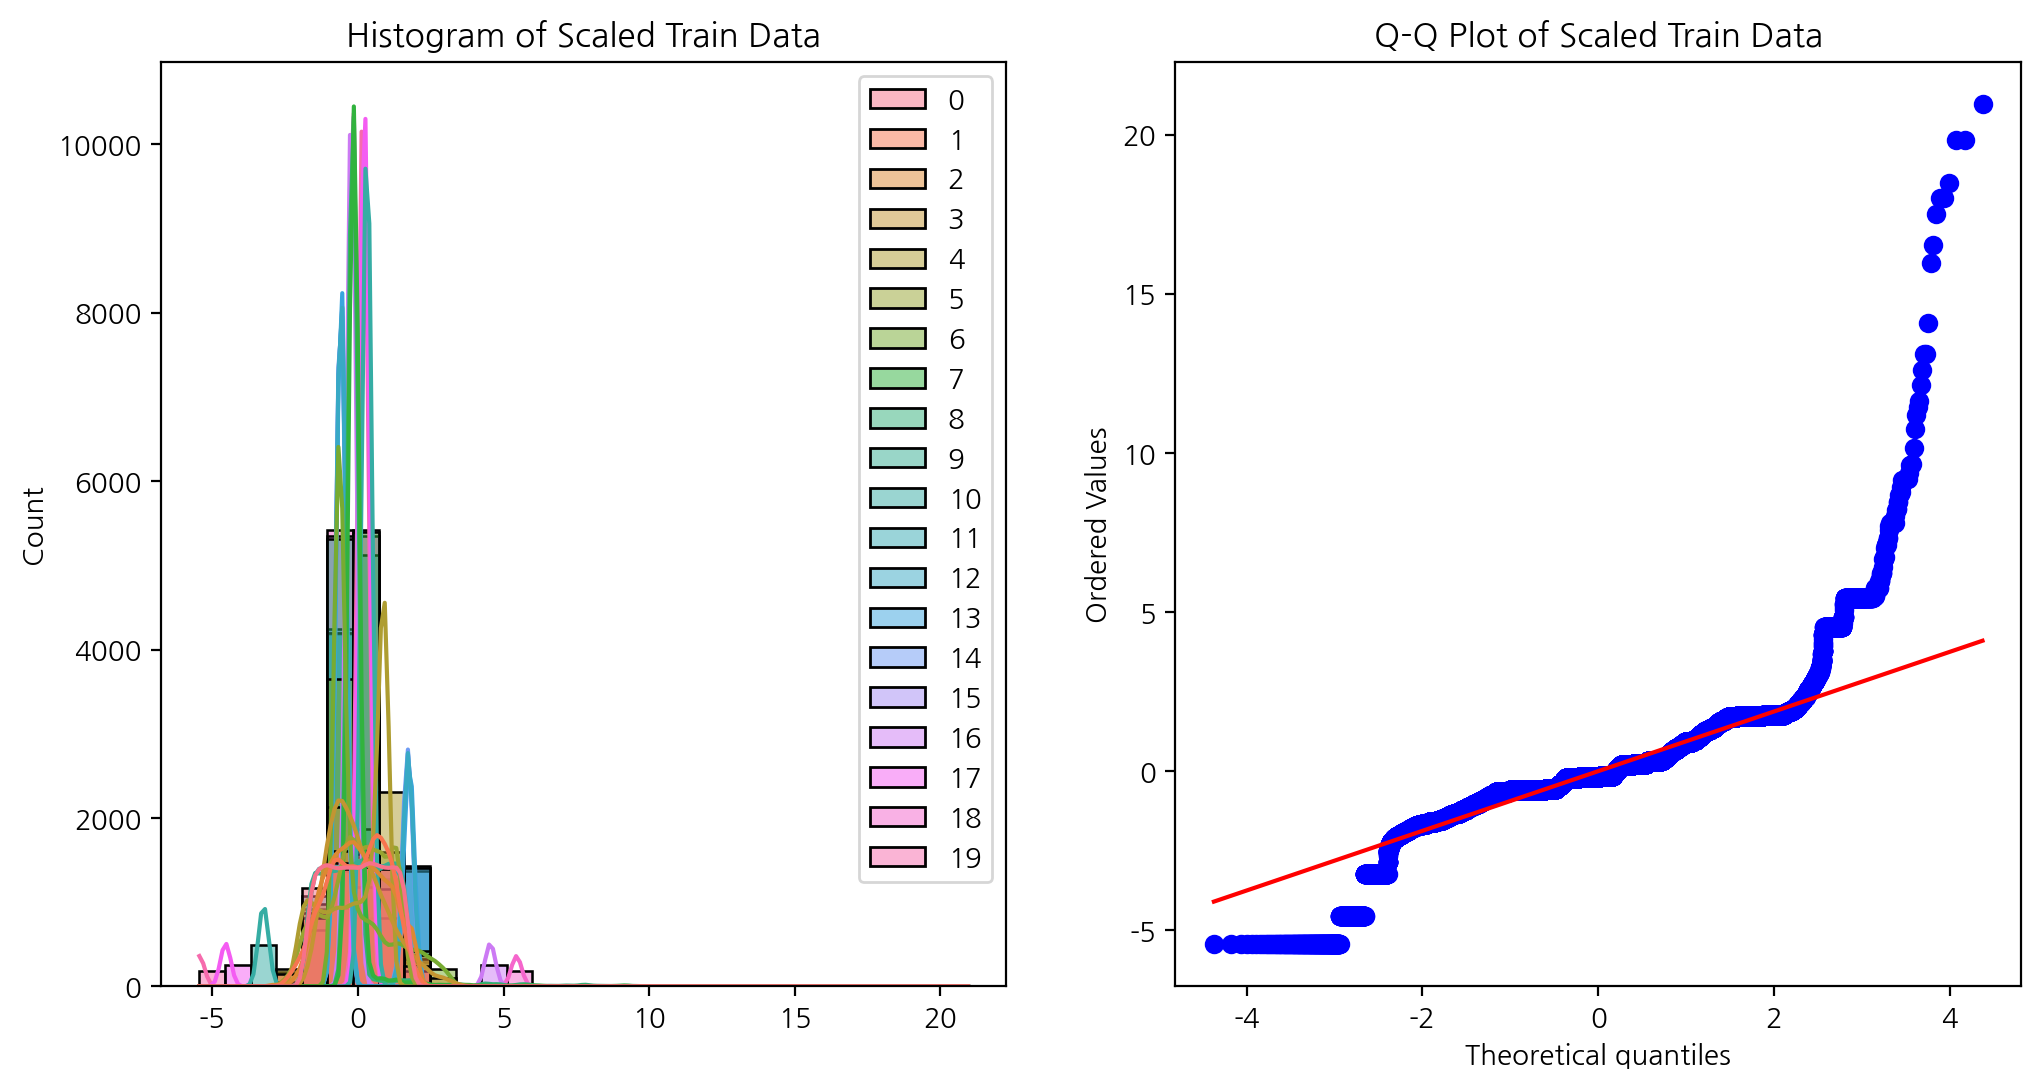

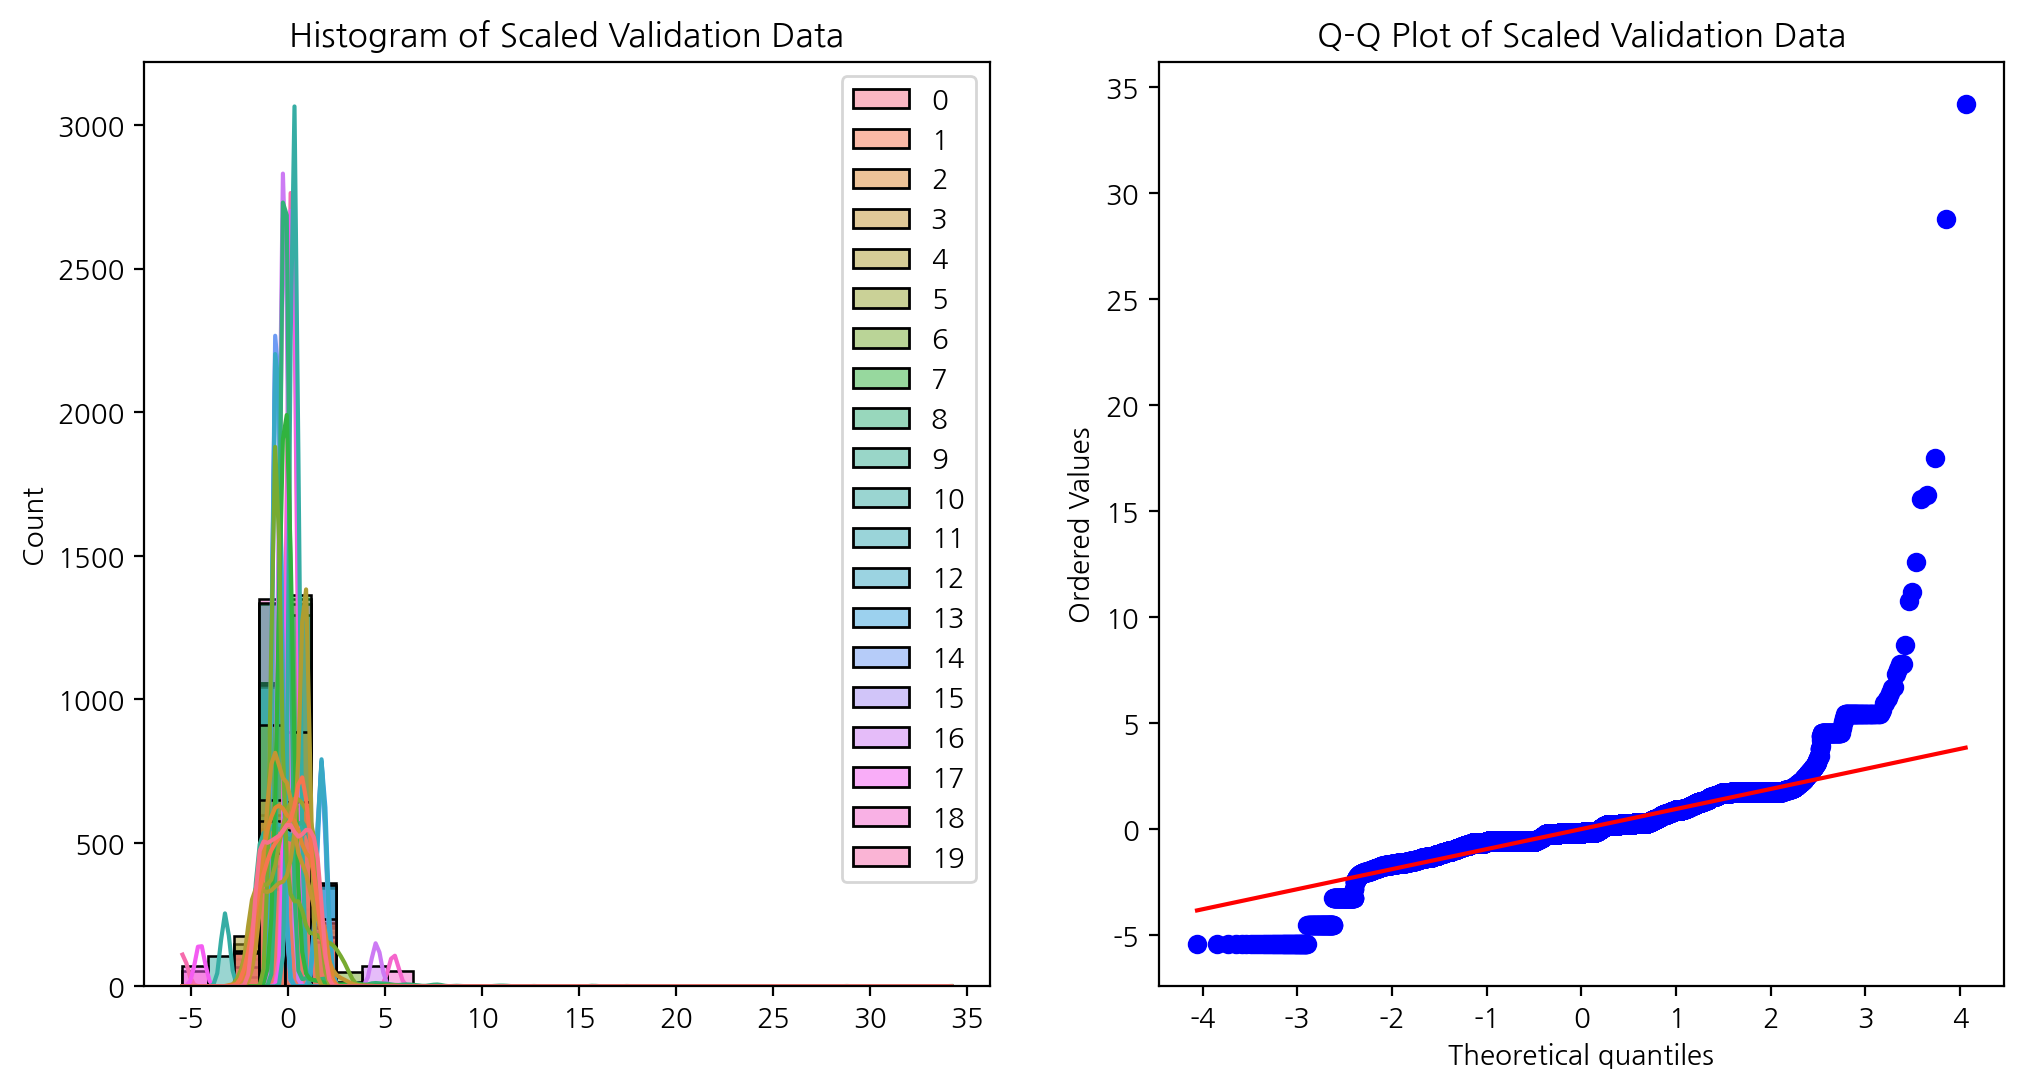

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Train 데이터 히스토그램
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_train_scaled, kde=True, bins=30)
plt.title('Histogram of Scaled Train Data')

# Train 데이터 Q-Q 플롯
plt.subplot(1, 2, 2)
stats.probplot(X_train_scaled.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Scaled Train Data')

plt.show()

# Validation 데이터 히스토그램
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_val_scaled, kde=True, bins=30)
plt.title('Histogram of Scaled Validation Data')

# Validation 데이터 Q-Q 플롯
plt.subplot(1, 2, 2)
stats.probplot(X_val_scaled.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Scaled Validation Data')

plt.show()
